In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
batch = 64
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

mnist_dataloader = DataLoader(mnist, shuffle=True, batch_size=batch)

In [3]:
import numpy as np
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.output = nn.Sequential(nn.Linear(100, 256),#雜訊是長度100的tensor
                                    nn.LeakyReLU(),
                                    nn.Linear(256, 512),
                                    nn.LeakyReLU(),
                                    nn.Linear(512, 1024),
                                    nn.LeakyReLU(),
                                    nn.Linear(1024, 784),
                                    nn.Tanh())#輸出值域要藉於-1~1
    def forward(self, batch_size : int, use_gpu = False):
        x = torch.rand((batch_size, 100))
        if (use_gpu): 
            x = x.to(device="cuda", dtype=torch.float32)
        return self.output(x)
    def generate_image(self):
        image = self.forward(batch_size=1)
        image = image.view(-1, 28, 28).detach().numpy()
        image = (image + 1) * 255 / 2
        return image

In [4]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.output = nn.Sequential(nn.Linear(784, 1024),
                                    nn.LeakyReLU(),
                                    nn.Dropout(0.3),
                                    nn.Linear(1024, 512),
                                    nn.LeakyReLU(),
                                    nn.Dropout(0.2),
                                    nn.Linear(512, 256),
                                    nn.LeakyReLU(),
                                    nn.Dropout(0.2),
                                    nn.Linear(256, 1),
                                    nn.Sigmoid()
                                    )
    def forward(self, x):
        x = x.view(-1, 784)
        return self.output(x)

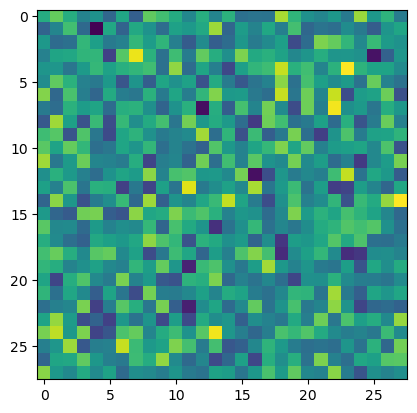

In [5]:
generator = Generator()
classifier = Classifier()


image = generator.generate_image()
plt.imshow(image[0])
plt.show()

In [6]:
use_gpu = torch.cuda.is_available()

epoch = 100
lr = 0.0002
beta = 0.5, 0.999

optim_G = optim.Adam(generator.parameters(), lr=lr, betas=beta)
optim_C = optim.Adam(classifier.parameters(), lr=lr, betas=beta)
loss_function = nn.BCELoss()

fake_label = torch.ones(batch)#整個再騙的標籤會一直用到

if (use_gpu):
    print("GPU")
    loss_function = loss_function.to(device="cuda", dtype=torch.float32)
    #generator = generator.to(device="cuda", dtype=torch.float32)
    classifier = classifier.to(device="cuda", dtype=torch.float32)
    fake_label = fake_label.to(device="cuda", dtype=torch.float32)

GPU


epoch: 1:
classifier loss: 0.010275915548295649
generator loss: 0.054965219311104825


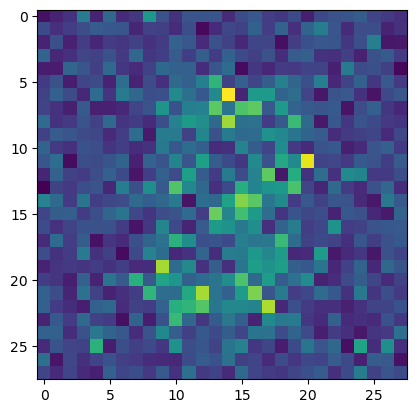

epoch: 2:
classifier loss: 0.011495627079340588
generator loss: 0.019150826288814125
epoch: 3:
classifier loss: 0.02070735356738372
generator loss: 0.020608932368960404


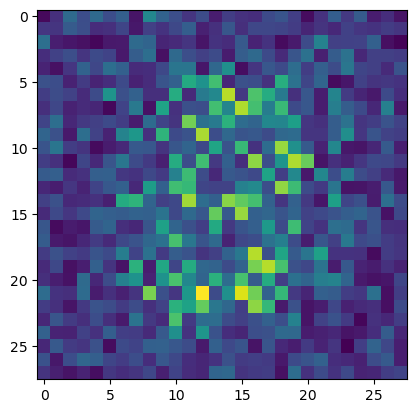

epoch: 4:
classifier loss: 0.027312017369925643
generator loss: 0.02214395635614611
epoch: 5:
classifier loss: 0.017652761915578574
generator loss: 0.01608320895995534


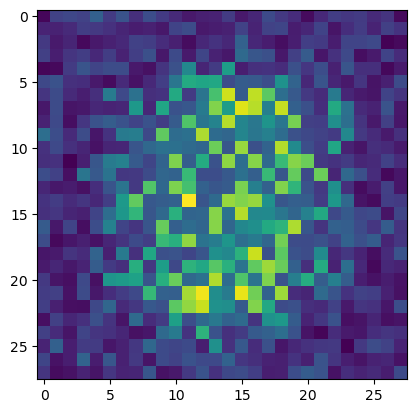

epoch: 6:
classifier loss: 0.016845613392245145
generator loss: 0.023065117782685853
epoch: 7:
classifier loss: 0.019562080859018418
generator loss: 0.01642727214308666


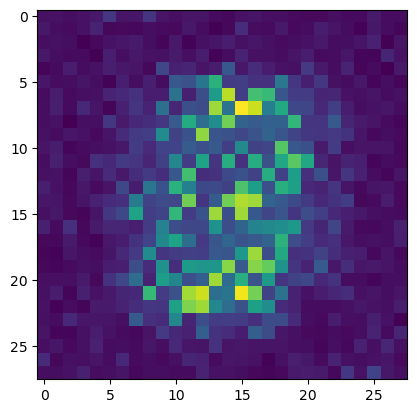

epoch: 8:
classifier loss: 0.013492919078704205
generator loss: 0.02903277873853141
epoch: 9:
classifier loss: 0.032420385535877394
generator loss: 0.018902458116547644


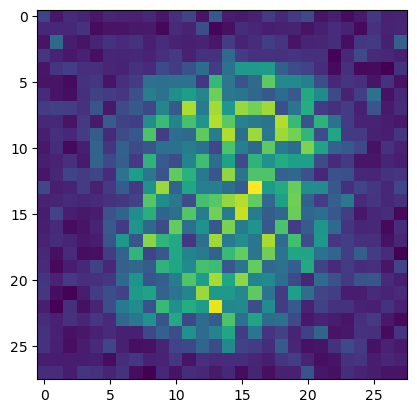

epoch: 10:
classifier loss: 0.027427335655324497
generator loss: 0.024878340715860946
epoch: 11:
classifier loss: 0.00958741320715114
generator loss: 6.1124873009861815


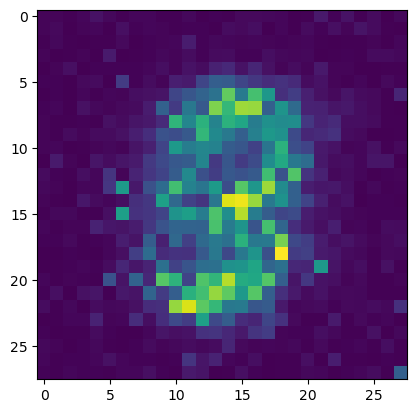

epoch: 12:
classifier loss: 0.054661759945202865
generator loss: 0.013823457502071883
epoch: 13:
classifier loss: 0.00893111577578554
generator loss: 0.023752875742629045


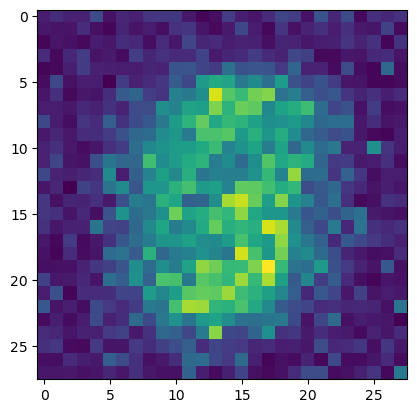

epoch: 14:
classifier loss: 0.01764321351398832
generator loss: 0.014499995874873153
epoch: 15:
classifier loss: 0.01973252755567137
generator loss: 99.8497329866454


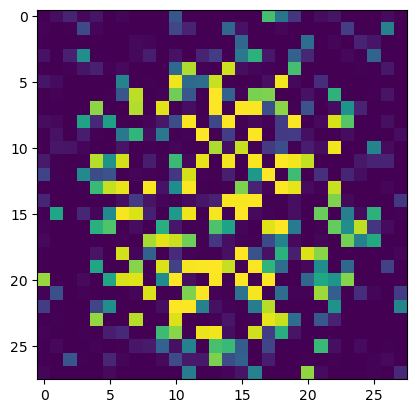

epoch: 16:
classifier loss: 1.0591894752389426e-05
generator loss: 100.0
epoch: 17:


KeyboardInterrupt: 

In [7]:
classifier_loss = []
generator_loss = []
for i in range(epoch):
    print(f"epoch: {i + 1}:")
    
    classifier_loss_epoch = 0
    generator_loss_epoch = 0
    count = 0
    classifier.train()
    for x, y in mnist_dataloader:
        count += 1
        optim_C.zero_grad()

        #reshape mnist data
        x = x.view(-1, 784)     
        #生成假資料
        fake_mnist = generator(batch_size=len(x))#不要被訓練到

        #合併資料
        train_data = torch.cat((x, fake_mnist))                        
        train_label = torch.cat((torch.ones(len(x)), torch.zeros(len(x))))

        #生成隨機排序
        random_indice = torch.randperm(2 * len(x))

        #隨機分布
        train_data = train_data[random_indice] 
        train_label = train_label[random_indice]

        
        if (use_gpu): 
            train_data = train_data.to(device="cuda", dtype=torch.float32)
            train_label = train_label.to(device="cuda", dtype=torch.float32)

        predict = classifier(train_data)

        train_label = train_label.view(predict.shape)

        #反向傳播
        c_loss = loss_function(predict, train_label)
        c_loss.backward()
        optim_C.step()

        
        classifier_loss_epoch += c_loss.item()
    
    print(f"classifier loss: {classifier_loss_epoch / count}")
    classifier_loss.append(classifier_loss_epoch / count)


    #訓練生成器
    classifier.eval()
    
    if (use_gpu): generator = generator.to(device="cuda", dtype=torch.float32)
        
    for j in range(count):
        optim_G.zero_grad()

        fake_mnist = generator(batch_size=batch, use_gpu=use_gpu)
        
        predict = classifier(fake_mnist)

        fake_label = fake_label.view(predict.shape)
        #反向傳播
        g_loss = loss_function(predict, fake_label)
        g_loss.backward()
        optim_G.step()

        

        generator_loss_epoch += g_loss.item()

    if (use_gpu):generator = generator.to(device="cpu", dtype=torch.float32)
        
    
    
    print(f"generator loss: {generator_loss_epoch / count}")
    print("===========================================")
    generator_loss.append(generator_loss_epoch / count)

    torch.cuda.empty_cache

    if (i % 2 == 0):
        fake_image = generator.generate_image()
        plt.imshow(fake_image[0])
        plt.show()
